# 实验二：基于霍夫变换的车道线检测

## 1. 实验背景与环境配置

**算法分析：**
车道线检测是自动驾驶感知层的核心任务之一。在经典计算机视觉领域，该任务通常被建模为“边缘检测 + 几何形状拟合”的问题。
* **OpenCV (`cv2`)**: 提供了底层的图像处理算子（如 Canny, HoughLines）。
* **NumPy**: 图像在计算机中本质上是矩阵，NumPy 用于高效的矩阵运算和掩膜（Mask）生成。
* **Matplotlib**: 用于在 Notebook 中可视化处理过程中的中间结果（如边缘图、掩膜图），便于调试参数。

本实验将通过流水线（Pipeline）的方式处理图像，逐步提取车道特征。

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用于正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用于正常显示负号

# 设置 Jupyter Notebook 的命令，使图像直接嵌入页面显示
%matplotlib inline

print("环境配置完成。OpenCV版本:", cv2.__version__)

环境配置完成。OpenCV版本: 4.12.0


## 2. 图像预处理：降维与去噪

**算法分析：**
在进行边缘检测之前，必须对原始图像进行预处理，主要包含两个步骤：

1.  **灰度化 (Grayscale Conversion)**:
    * **原理**: 彩色图像包含 R, G, B 三个通道，数据量大且受环境光色温影响大。车道线识别主要依赖于**亮度突变**（如白色车道线与黑色沥青路的对比），而非色彩信息。
    * **公式**: $Y = 0.299R + 0.587G + 0.114B$。将三通道降维至单通道，显著减少后续计算量。

2.  **高斯模糊 (Gaussian Blur)**:
    * **原理**: 校园道路环境复杂，路面可能有树影、石子或裂缝，这些高频纹理会在边缘检测中产生大量噪点（假阳性）。
    * **操作**: 使用高斯核与图像进行卷积。
    * **参数分析 (`kernel_size`)**: 核大小必须是奇数（如 3, 5, 7）。对于分辨率较高的手机拍摄图片，推荐使用 **5x5** 或 **7x7** 的核。核越大，图像越模糊，抗噪能力越强，但可能会模糊掉远处的细小车道线。

当前图像 Shape: (1279, 1616, 3)
当前图像数据类型: uint8


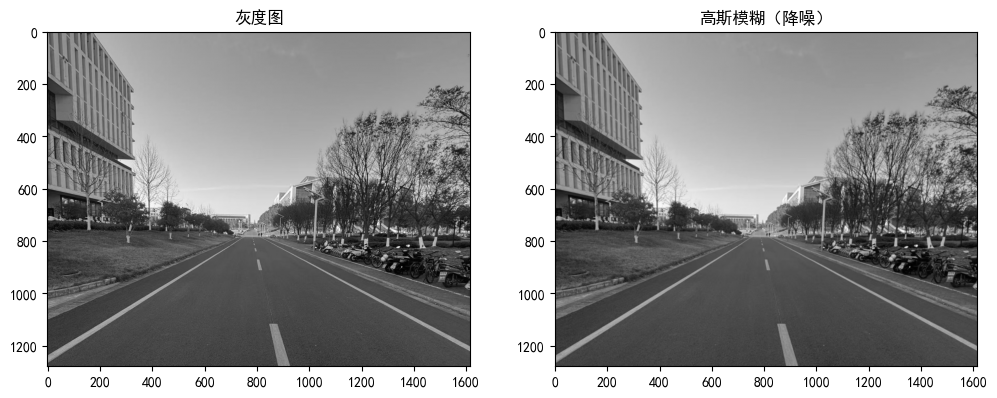

In [2]:
def grayscale(img):
    """将 RGB 图像转换为灰度图"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def gaussian_blur(img, kernel_size):
    """
    使用高斯核对图像进行平滑处理
    kernel_size: 高斯核大小 (例如 5 表示 5x5 矩阵)
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# --- 执行代码 ---
# 读取图片 (请修改为你的文件名)
image = mpimg.imread('campus_road.jpg')

# 如果图片读取为浮点数 (0-1)，则乘以 255 并转为整数 (0-255)
if image.dtype == np.float32 or image.dtype == np.float64:
    image = (image * 255).astype(np.uint8)

# 通道数转换 (4通道 -> 3通道)
# 如果图片有透明度通道 (RGBA)，去掉它，只保留 RGB
if len(image.shape) > 2 and image.shape[2] == 4:
    image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

print("当前图像 Shape:", image.shape)  # 必须是 (高度, 宽度, 3) 才能运行成功
print("当前图像数据类型:", image.dtype)  # 应该是 uint8

# 1. 灰度化
gray_img = grayscale(image)

# 2. 高斯模糊
kernel_size = 5
blur_img = gaussian_blur(gray_img, kernel_size)

# 展示对比
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_title('灰度图')
ax1.imshow(gray_img, cmap='gray')
ax2.set_title('高斯模糊（降噪）')
ax2.imshow(blur_img, cmap='gray')
plt.show()


## 3. Canny 边缘检测 (Edge Detection)

**算法分析：**
Canny 算子是目前最优的边缘检测算法之一，它通过计算像素梯度的幅值和方向来定位边缘。

**核心步骤：**
1.  **计算梯度**: 使用 Sobel 算子计算水平 ($G_x$) 和垂直 ($G_y$) 方向的导数，得到梯度幅值 $G = \sqrt{G_x^2 + G_y^2}$。
2.  **非极大值抑制**: 细化边缘，确保边缘只有 1 像素宽。
3.  **双阈值 (Double Thresholding) 机制**: 
    * **High Threshold**: 高于此值的像素被确认为“强边缘”。
    * **Low Threshold**: 低于此值的被抛弃；介于两者之间的像素，只有当它们与“强边缘”相连时才会被保留。

**针对校园道路的参数调整：**
* **Low Threshold**: 建议设为 50 左右。如果太低，会检测到路面的微小裂缝。
* **High Threshold**: 建议设为 150 左右（通常保持 1:2 或 1:3 的比例）。在树影斑驳的校园路面上，适当调高此值可以过滤掉阴影边缘。
* **本实验调参值**: `canny_low=50`, `canny_high=150`。


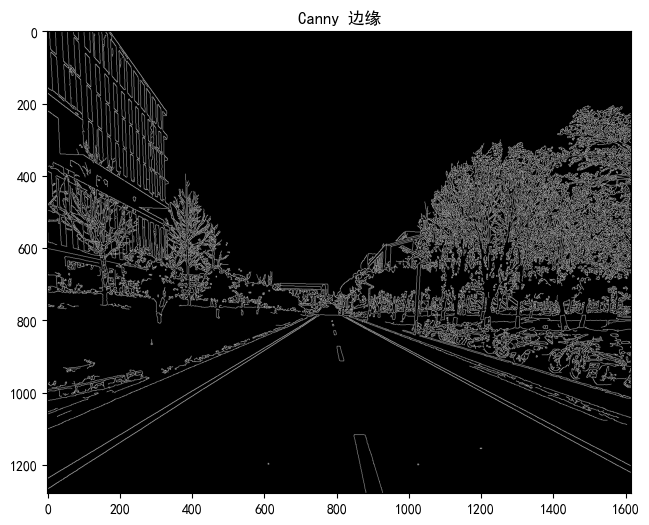

In [3]:
def canny(img, low_threshold, high_threshold):
    """应用 Canny 边缘检测"""
    return cv2.Canny(img, low_threshold, high_threshold)

# --- 执行代码 ---
canny_low = 50
canny_high = 150

edges = canny(blur_img, canny_low, canny_high)

# 展示边缘检测结果
plt.figure(figsize=(10, 6))
plt.title("Canny 边缘")
plt.imshow(edges, cmap='gray')
plt.show()


## 4. 感兴趣区域 (ROI) 掩膜提取

**算法分析：**
边缘检测是全局的，它会把天空、树木、建筑物的轮廓都提取出来。为了让霍夫变换只关注车道线，我们需要定义一个**Mask（掩膜）**。

**几何逻辑：**
* **视点假设**: 假设相机固定在车头或手持拍摄，车道线必然汇聚于图像中心的远点，并延伸至图像底部的左右两侧。
* **梯形区域**: 我们定义一个梯形多边形：
    * 底边：图像底部（覆盖车头前方）。
    * 顶边：图像中心偏下位置（地平线下方）。
* **位运算**: 使用 `cv2.bitwise_and` 操作，将掩膜与边缘图相乘。掩膜外（黑色，值为0）的区域会被强制置零，掩膜内（白色，值为1）的区域保留。

**注意**: 校园道路通常较窄，且可能有行人，所以 ROI 的顶边不要设置得太宽。本图像调参后顶边高度约为 **0.55H**，左右顶点约为 **0.3W** 和 **0.7W**，用于覆盖车道线并排除两侧杂波。实际使用可根据图像微调。


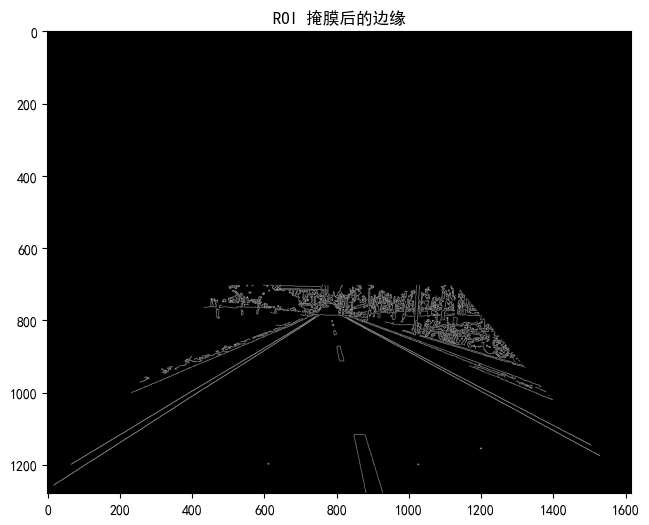

In [4]:
def region_of_interest(img, vertices):
    """
    应用图像掩膜
    img: 输入图像 (Canny 结果)
    vertices: 多边形顶点坐标 (numpy array)
    """
    mask = np.zeros_like(img)

    # 定义掩膜填充颜色 (对于灰度图是 255)
    ignore_mask_color = 255

    # 填充多边形
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # 执行与操作，保留感兴趣区域
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# --- 执行代码 ---
imshape = image.shape
height = imshape[0]
width = imshape[1]

# 定义梯形顶点：(左下, 左上, 右上, 右下)
# 这里的比例参数需要根据你拍摄的具体图片微调
vertices = np.array([[(0, height),
                      (width * 0.3, height * 0.55),  # 左上点
                      (width * 0.7, height * 0.55),  # 右上点
                      (width, height)]], dtype=np.int32)

masked_edges = region_of_interest(edges, vertices)

# 展示 ROI 结果
plt.figure(figsize=(10, 6))
plt.title("ROI 掩膜后的边缘")
plt.imshow(masked_edges, cmap='gray')
plt.show()


## 5. 霍夫变换与车道线拟合 (Probabilistic Hough Transform)

**算法分析：**
这是实验的核心步骤，用于从离散的边缘点中提取数学上的直线方程。

**数学原理：**
* **参数空间映射**: 笛卡尔坐标系中的一条直线 $y=kx+b$ 无法表示垂直线。霍夫变换使用极坐标 $(\rho, \theta)$ 表示直线：$\rho = x \cos \theta + y \sin \theta$。
* **投票机制**: 图像空间中的每一个边缘点，对应参数空间中的一条正弦曲线。如果多条正弦曲线交于一点 $(\rho_0, \theta_0)$，则说明这些点共线。

**HoughLinesP 参数详解：**
本实验使用累计概率霍夫变换 (`HoughLinesP`)，它比标准霍夫变换更快，且直接返回线段端点。
* `rho` (1): 距离精度，设为 1 像素。
* `theta` (np.pi/180): 角度精度，设为 1 度。
* `threshold` (150): **投票阈值**。只有当一条直线上至少有 150 个像素点时，才会被认定为直线。
* `minLineLength` (90): **最小线长**。小于此长度的线段被视为噪点（如路面斑点）。
* `maxLineGap` (50): **最大断裂距离**。它允许算法把中间断开不超过 50 像素的两条线段连接成一条线。

**线段融合与延伸：**
为避免同一车道出现多条短线段，先按斜率符号划分左右车道并以线段长度加权平均得到代表线。随后根据线段的高度分布选取共同的上端点 `y2_common`，结合 `y2_ratio` 与 `y2_percentile` 控制延伸长度，避免过长或左右不一致。辅助参数 `min_slope=0.5` 用于过滤接近水平的线段。


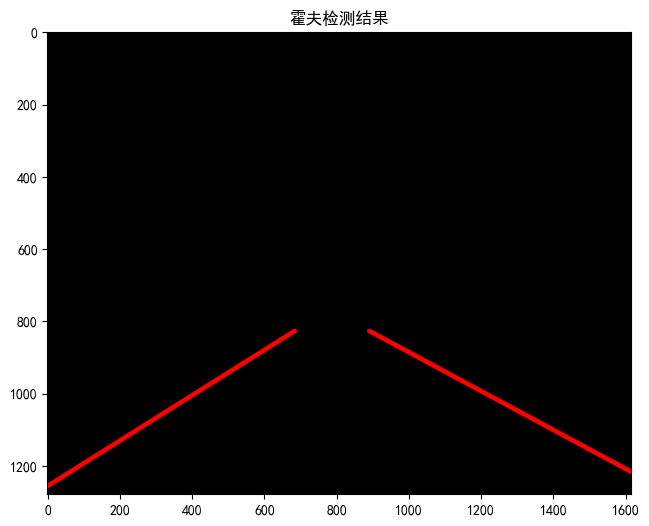

In [5]:
def make_line_points(y1, y2, line):
    """根据斜率和截距计算线段端点"""
    if line is None:
        return None
    slope, intercept = line
    if slope == 0:
        return None
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return (x1, y1, x2, y2)


def average_slope_intercept(lines, min_slope=0.5):
    """按左右车道分组并用线段长度加权平均"""
    left = []
    right = []
    left_y = []
    right_y = []
    if lines is None:
        return None, None, [], []
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2: # 忽略垂直线（斜率无穷大），防止报错
                continue
            slope = (y2 - y1) / (x2 - x1) # 计算斜率 k = (y2-y1) / (x2-x1)
            if abs(slope) < min_slope: # 如果斜率太小（绝对值 < 0.5），说明线接近水平，通常是路面的减速带、阴影边界或引擎盖
                continue
            intercept = y1 - slope * x1 # 计算截距 b = y - kx
            length = np.hypot(x2 - x1, y2 - y1) # 计算线段长度（勾股定理），用于加权平均

            # --- 分类逻辑 (图像坐标系 Y 轴向下) ---
            # 斜率 < 0：左上到右下？不对。
            # 在图像坐标系中：
            # 左车道：从底部(x小, y大) 到 远处(x大, y小) -> dx>0, dy<0 -> 斜率 < 0
            # 右车道：从底部(x大, y大) 到 远处(x小, y小) -> dx<0, dy<0 -> 斜率 > 0
            if slope < 0:
                left.append((slope, intercept, length))
                left_y.extend([y1, y2])
            else:
                right.append((slope, intercept, length))
                right_y.extend([y1, y2])

    def weighted_avg(lines_group):
        if not lines_group:
            return None
        slopes = np.array([l[0] for l in lines_group])
        intercepts = np.array([l[1] for l in lines_group])
        weights = np.array([l[2] for l in lines_group])
        slope = np.dot(weights, slopes) / weights.sum()
        intercept = np.dot(weights, intercepts) / weights.sum()
        return slope, intercept

    left_lane = weighted_avg(left)
    right_lane = weighted_avg(right)
    return left_lane, right_lane, left_y, right_y


def pick_y2(y_values, y2_default, y2_percentile=20):
    """根据线段高度分布选取稳定的上端点"""
    if not y_values:
        return y2_default
    y_candidate = int(np.percentile(y_values, y2_percentile))
    return max(y2_default, y_candidate)


def draw_lines(img, lines, color=[255, 0, 0], thickness=12, min_slope=0.5, y2_ratio=0.6, y2_percentile=20):
    """为左右车道各绘制一条代表直线"""
    if lines is None:
        return
    left_lane, right_lane, left_y, right_y = average_slope_intercept(lines, min_slope=min_slope)
    y1 = img.shape[0]
    y2_default = int(img.shape[0] * y2_ratio)
    all_y = left_y + right_y
    y2_common = pick_y2(all_y, y2_default, y2_percentile)

    for lane in (left_lane, right_lane):
        pts = make_line_points(y1, y2_common, lane)
        if pts is None:
            continue
        x1, y1, x2, y2 = pts
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,
                min_slope=0.5, y2_ratio=0.6, y2_percentile=20, thickness=12):
    """
    img: ROI 边缘图
    返回: 绘制了车道线的空白图像
    """
    # 运行概率霍夫变换
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                            minLineLength=min_line_len, maxLineGap=max_line_gap)

    # 创建黑底图用于画线
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    draw_lines(line_img, lines, thickness=thickness, min_slope=min_slope,
               y2_ratio=y2_ratio, y2_percentile=y2_percentile)
    return line_img

# --- 执行代码 ---
rho = 1
theta = np.pi/180
hough_threshold = 150
min_length = 90
max_gap = 50
min_slope = 0.5
y2_ratio = 0.6
y2_percentile = 20
line_thickness = 12

line_image = hough_lines(
    masked_edges,
    rho,
    theta,
    hough_threshold,
    min_length,
    max_gap,
    min_slope=min_slope,
    y2_ratio=y2_ratio,
    y2_percentile=y2_percentile,
    thickness=line_thickness,
)

plt.figure(figsize=(10, 6))
plt.title("霍夫检测结果")
plt.imshow(line_image)
plt.show()


## 6. 结果叠加与可视化

**算法分析：**
最后一步是将检测到的车道线（红线）与原始彩色图像融合，以便直观地评估检测效果。

**融合原理：**
使用 `cv2.addWeighted` 进行加权叠加。公式为：
$$Result = \alpha \cdot \text{Src1} + \beta \cdot \text{Src2} + \gamma$$
其中：
* $\alpha=0.8$: 原图权重，保持背景清晰。
* $\beta=1.0$: 线条权重，设为 1 确保车道线高亮显示。
* $\gamma=0$: 亮度偏移量。

**实验总结：**
通过上述步骤，我们实现了从自然场景中提取几何特征的过程。如果结果中包含过多杂线，请检查 Canny 的 `canny_low` 是否过低，或提高 `hough_threshold`；如果两条线交叉成 X，可适当提高 `y2_ratio` 或 `y2_percentile`；如果只有一侧车道线，尝试降低 `min_slope` 或调整 ROI 顶边位置。


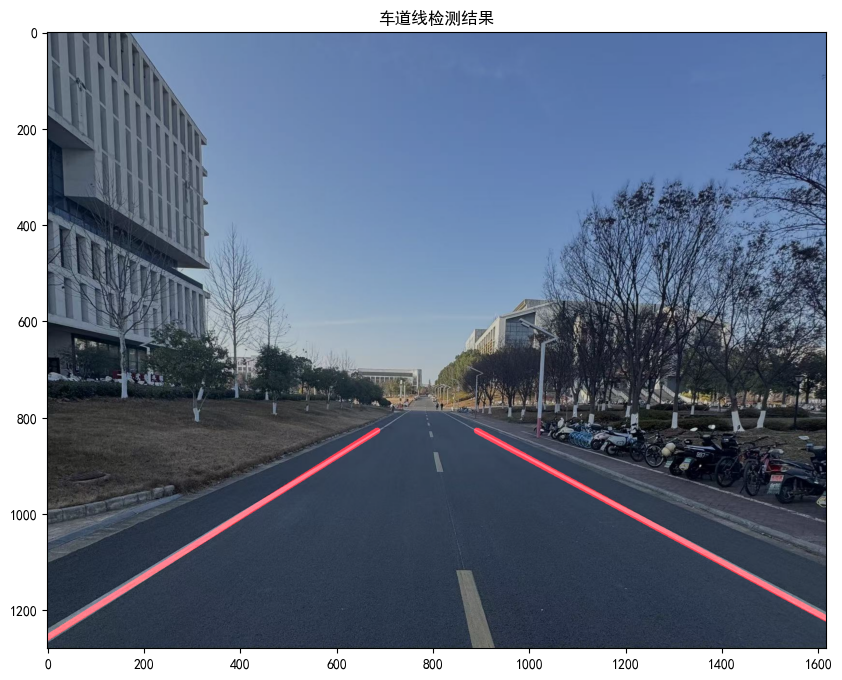

True

In [6]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    将 img (线条图) 叠加到 initial_img (原图) 上
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

# --- 执行代码 ---
final_result = weighted_img(line_image, image)

# 显示最终大图
plt.figure(figsize=(12, 8))
plt.imshow(final_result)
plt.title("车道线检测结果")
plt.show()

# 保存结果到文件
cv2.imwrite('output_campus_road.jpg', cv2.cvtColor(final_result, cv2.COLOR_RGB2BGR))


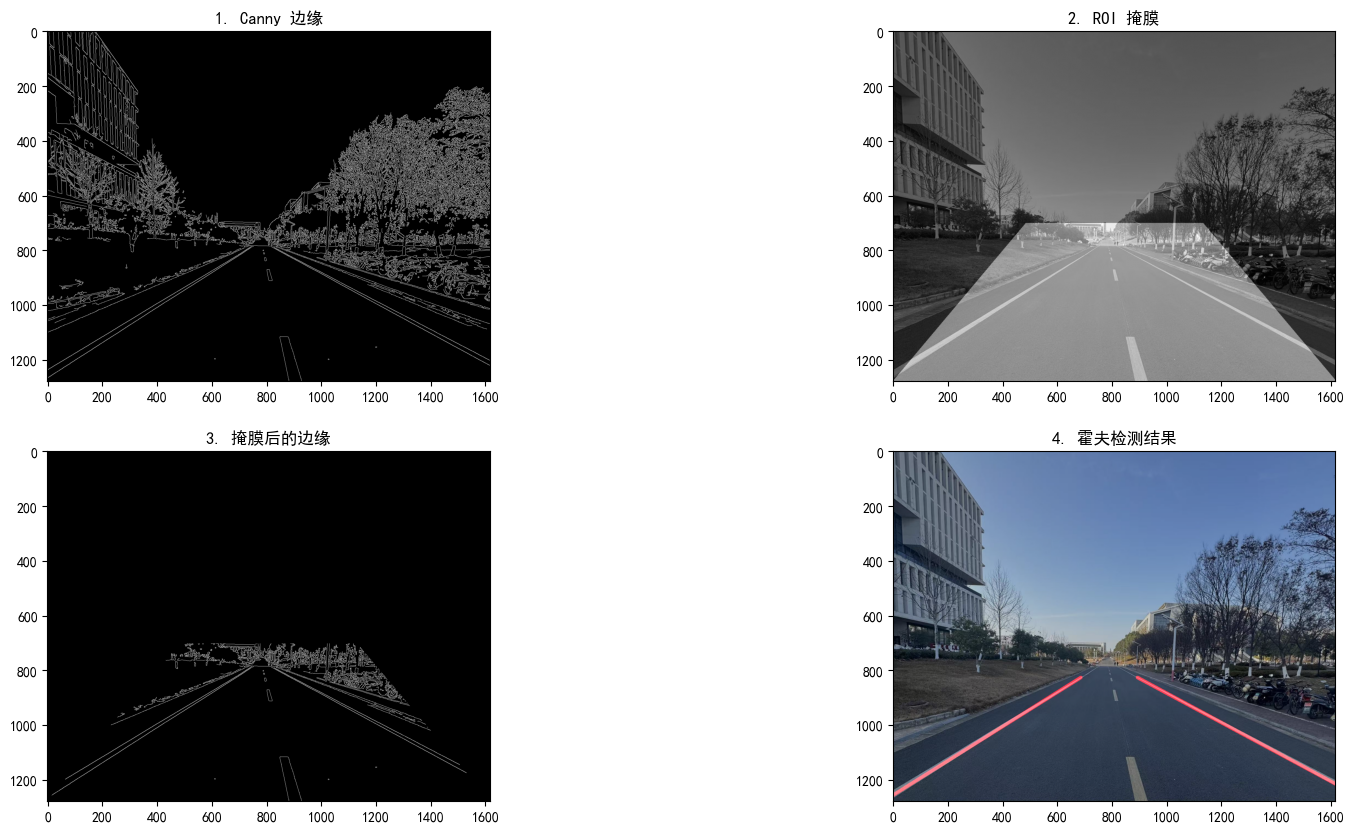

In [7]:
# --- 调试代码 ---

# 1) 在这里调参，直到结果满意
# 如果树影太多，提高 canny_low (例如 80)
# 如果两条线交叉成 X，提高 y2_ratio (例如 0.65)
# 如果线断裂，增大 max_gap (例如 50-100)
canny_low = 50
canny_high = 150
hough_threshold = 150
min_length = 90
max_gap = 50
min_slope = 0.5
y2_ratio = 0.6
y2_percentile = 20
line_thickness = 12

# 重新执行流程
gray_img = grayscale(image)
blur_img = gaussian_blur(gray_img, 5)
edges = canny(blur_img, canny_low, canny_high)

# 重新定义 ROI (最容易出错)
imshape = image.shape
height = imshape[0]
width = imshape[1]
# 这里的坐标需要你根据肉眼看图调整
vertices = np.array([[(0, height),
                      (width * 0.3, height * 0.55),
                      (width * 0.7, height * 0.55),
                      (width, height)]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)

# 霍夫变换
lines = cv2.HoughLinesP(masked_edges, 1, np.pi/180, hough_threshold, np.array([]),
                        minLineLength=min_length, maxLineGap=max_gap)
line_img = np.zeros((height, width, 3), dtype=np.uint8)
draw_lines(line_img, lines, thickness=line_thickness, min_slope=min_slope,
           y2_ratio=y2_ratio, y2_percentile=y2_percentile)

# --- 画出四张图进行诊断 ---
plt.figure(figsize=(20, 10))

plt.subplot(2,2,1)
plt.title("1. Canny 边缘")
plt.imshow(edges, cmap='gray')
# 诊断：如果这里噪点太多，说明 Canny 阈值偏低或需要颜色过滤。

plt.subplot(2,2,2)
plt.title("2. ROI 掩膜")
# 画出 ROI 范围给肉眼看
roi_check = np.zeros_like(gray_img)
cv2.fillPoly(roi_check, vertices, 255)
plt.imshow(cv2.addWeighted(gray_img, 0.6, roi_check, 0.4, 0), cmap='gray')
# 诊断：如果梯形没有罩住车道线，需要调整 vertices 的坐标。

plt.subplot(2,2,3)
plt.title("3. 掩膜后的边缘")
plt.imshow(masked_edges, cmap='gray')
# 诊断：如果这里看不到车道线，说明 ROI 或 Canny 参数不合适。

plt.subplot(2,2,4)
plt.title("4. 霍夫检测结果")
combined = weighted_img(line_img, image)
plt.imshow(combined)
# 诊断：如果这里杂线较多，说明掩膜后的边缘仍有噪声。

plt.show()
